In [1]:
!pip install -U xarray

Requirement already up-to-date: xarray in /home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages (0.15.1)


In [2]:
import os
import sys

sys.path.append(os.path.expanduser("~/marineHeatWaves"))
import marineHeatWaves as mh

import xarray as xr
import numpy as np
import zarr

from dask.distributed import Client

from datetime import date, datetime

from functools import partial

import gcsfs
import s3fs 
import boto3

import cartopy.crs as ccrs
import cartopy.feature as cf

from pandas import Timestamp

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool

from numba import float64, guvectorize, jit
import numba

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

In [3]:
# from dask_kubernetes import KubeCluster
# cluster = KubeCluster()
# cluster.adapt(minimum=0, maximum=10) 

In [4]:
client = Client()

In [5]:
client.cluster.scale(8)

In [6]:
xr.__version__ ## >=0.15.1 REQUIRED for vectorization bugfix

'0.15.1'

In [7]:
# client = Client(cluster.scheduler_address)

# Alternative MHW processing 

In [8]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [9]:
oisst

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,14386 Tasks,8220 Chunks
Type,float32,numpy.ndarray


In [37]:
# s
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).persist()


Text(0.0, 1.0, 'Data Region')

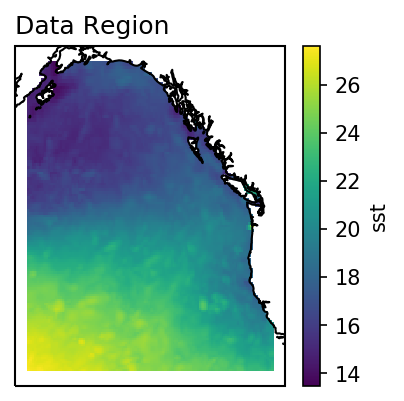

In [38]:
fig = plt.figure(figsize=(3,3), dpi=150)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)
oisst_pnw.sst.max('time').plot(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m', facecolor='none', edgecolor='black'))
plt.title("Data Region", loc='left')

In [40]:
oisst_pnw.sst.data

,Array,Chunk
Bytes,916.34 MB,2.80 MB
Shape,"(13636, 120, 140)","(100, 50, 140)"
Count,411 Tasks,411 Chunks
Type,float32,numpy.ndarray


In [12]:
oisst_small = oisst_pnw.isel(lat=slice(0,3), lon=slice(0,3))

## generate function to turn mhw output into multi xarrays

In [41]:
SAVED_PARAMS = [
    'intensity_max',
    'intensity_cumulative',
    'intensity_var',
    'intensity_mean',
    'rate_onset',
    'rate_decline',
    'index_start', 
    'index_end',
    'index_peak',
    'duration'
]

In [42]:
dim_idx_mapping = {
        **{
            i : SAVED_PARAMS[i]
            for i in range(len(SAVED_PARAMS))
        }, 
        **{
            len(SAVED_PARAMS): 'mhw',
            len(SAVED_PARAMS) + 1 : 'clim'
        }
}

In [43]:
dim_idx_mapping

{0: 'intensity_max',
 1: 'intensity_cumulative',
 2: 'intensity_var',
 3: 'intensity_mean',
 4: 'rate_onset',
 5: 'rate_decline',
 6: 'index_start',
 7: 'index_end',
 8: 'index_peak',
 9: 'duration',
 10: 'mhw',
 11: 'clim'}

In [44]:
def cp_guvectorize(*args, **kwargs):
    """Same as :func:`numba.guvectorize`, but can be used to decorate dynamically
    defined function and then pickle them with
    `cloudpickle <https://pypi.org/project/cloudpickle/>`_.
    On the other hand, it can't be called from another jit-compiled function.
    """

    def decorator(func):
        return _PickleableGUVectorized(func, args, kwargs)

    return decorator


class _PickleableGUVectorized:
    def __init__(self, func, guvectorize_args, guvectorize_kwargs):
        self.args = func, guvectorize_args, guvectorize_kwargs
        decorator = numba.guvectorize(*guvectorize_args, **guvectorize_kwargs)
        self.ufunc = decorator(func)

    def __reduce__(self):
        return _PickleableGUVectorized, self.args

    def __call__(self, *args, **kwargs):
        return self.ufunc(*args, **kwargs)

In [45]:
# @cp_guvectorize("(float64[:], float64[:], float64[:])", "(n), (n) -> (n)")
def mhw_1d(temps, time):
    SAVED_PARAMS_loc = SAVED_PARAMS.copy()
    if(np.isnan(temps).any()): return np.zeros((len(SAVED_PARAMS_loc) + 2, time.shape[0]))

    ordinals =  np.array([Timestamp(t).toordinal() for t in time])
    dets = mh.detect(ordinals, temps.copy())
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = [
        np.zeros_like(time, dtype='float64')
        for _ in range(len(SAVED_PARAMS_loc)) 
    ]
    arrays.append(np.zeros_like(time, dtype='int'))
    
    for event_i in range(events):
        start_date = dets[0]['index_start'][event_i]
        end_date = dets[0]['index_end'][event_i]
        
        # set binary param
        arrays[-1][start_date:end_date] = event_i
        # set all params
        for _i, param in enumerate(SAVED_PARAMS_loc):
#             print(f'saving param {param}')
            param_data = dets[0][param][event_i]
            arrays[_i][start_date:end_date] = param_data
                
        
    clim = dets[1]['thresh'] 
        
    return np.array(
        arrays + [clim]
    )


In [46]:
a = xr.apply_ufunc(
    mhw_1d, 
    oisst_pnw.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}), 
    oisst_pnw.time, 
    input_core_dims = [['time'], ['time']],
    output_core_dims=[["param","time"]],
    output_dtypes=['float64'],
    dask='parallelized', 
    output_sizes={"param": len(SAVED_PARAMS) + 2}, # + 2 for binary MHW detection parameter and climatology
    vectorize=True
)

In [50]:
ans = a.compute().to_dataset(dim='param').rename_vars(dim_idx_mapping)

MemoryError: Unable to allocate array with shape (5, 5, 12, 13636) and data type float64

In [26]:
ans.to_netcdf("/tmp/computed_mhws.nc")

In [27]:
region = ans.isel(lat=25, lon=56)

In [28]:
mhw_times = ans.isel(lat=25, lon=56).where(ans.isel(lat=0, lon=0).mhw, drop=True).time


(735234.0, 735963.0)

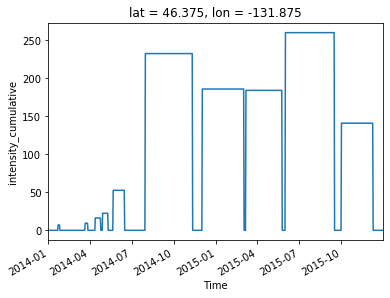

In [30]:
# region.clim.plot()
# plt.fill_between(mhw_times.values, region.sel(time=mhw_times.values).clim.values, oisst_small.isel(lat=0, lon=0).sel(time=mhw_times.values).sst.values)
# ans.mhw.isel(lat=0, lon=0).plot()
# oisst_pnw.isel(lat=25, lon=56).sst.plot()
region.intensity_cumulative.plot()
plt.xlim(['2014-01-01', '2015-12-31'])

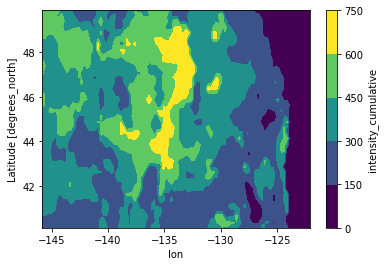

In [31]:
ans.sel(time=slice('2014-01-01', '2015-12-31')).intensity_cumulative.max(dim='time').plot.contourf()

## Upload as zarr to AWS S3 bucket

In [44]:
fs = s3fs.S3FileSystem()
s3_store = s3fs.S3Map("s3://mhw-stress/testregion", s3=fs)
compressor = zarr.Blosc(cname='zstd', clevel=3)
encoding = {vname: {'compressor': compressor} for vname in ans.data_vars}

In [46]:
ans.to_zarr(store=s3_store, encoding=encoding, consolidated=True)